In [16]:
import numpy as np
import matplotlib.pyplot as plt
from molecule import CaOH, CaH, mu_N, gI
from scipy.constants import h, k
%matplotlib inline

import qls
import utils as ut

# CaH+

In [1]:
# Taken from Chou et al.

gj_list: list[float] = [-1.35, -1.35, -1.35, -1.34, -1.34, -1.34, -1.34, -1.34, -1.33, -1.33, -1.33, -1.32, -1.32, -1.31, -1.31]

cij_list: list[float] = [8.27, 8.26, 8.26, 8.26, 8.26, 8.25, 8.25, 8.24, 8.24, 8.23, 8.22, 8.21, 8.20, 8.19, 8.18]

### B = 0: zero field

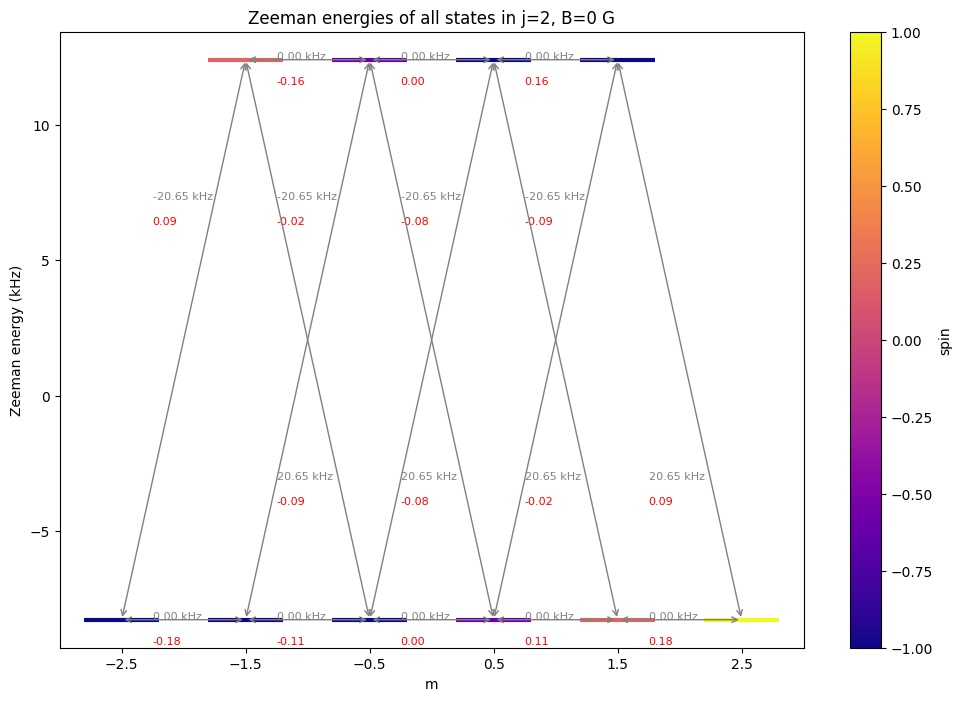

In [ ]:
cah = CaH.create_molecule_data(b_field_gauss=0, j_max=14, gj_list = gj_list, cij_list = cij_list)

# Manifold J=2
cah.plot_zeeman_levels(2)

### B = 0.3: Zeeman regime

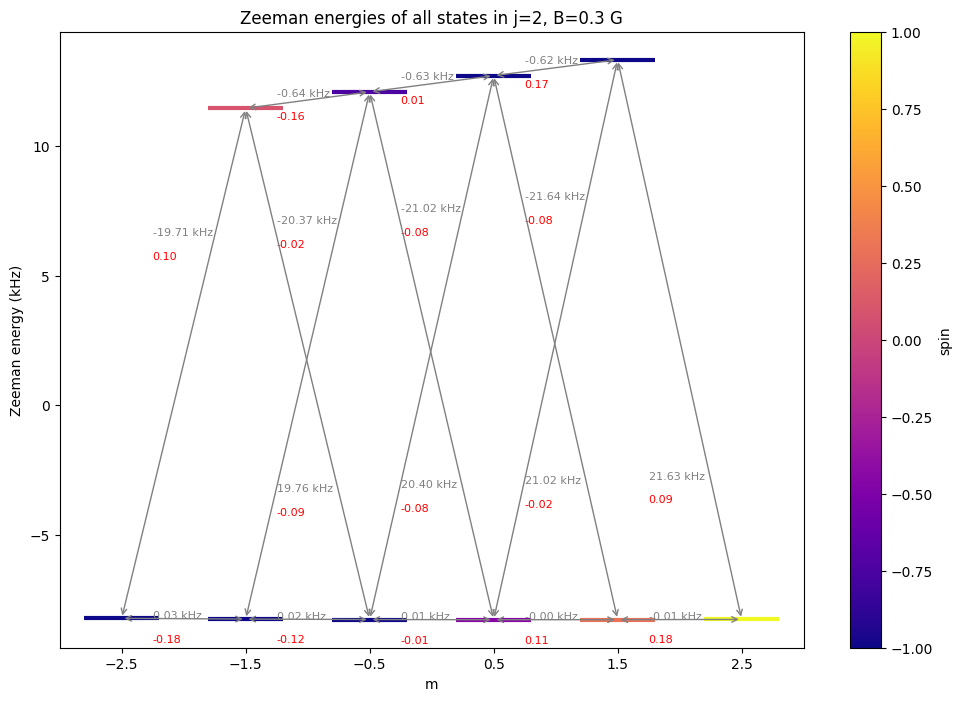

In [ ]:
cah = CaH.create_molecule_data(b_field_gauss=0.3, j_max=14, gj_list = gj_list, cij_list = cij_list)

# Manifold J=2
cah.plot_zeeman_levels(2)

### B = 3; Intermediate Regime

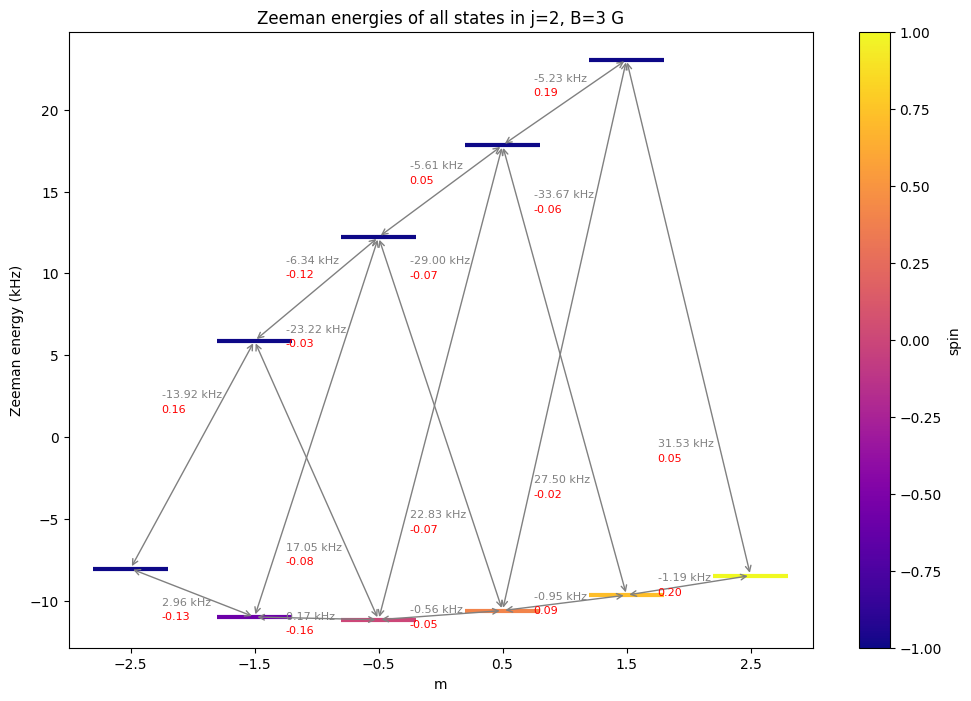

In [ ]:
cah = CaH.create_molecule_data(b_field_gauss=3, j_max=14, gj_list = gj_list, cij_list = cij_list)

# Manifold J=2
cah.plot_zeeman_levels(2)

### B = 10: Paschen Back regime

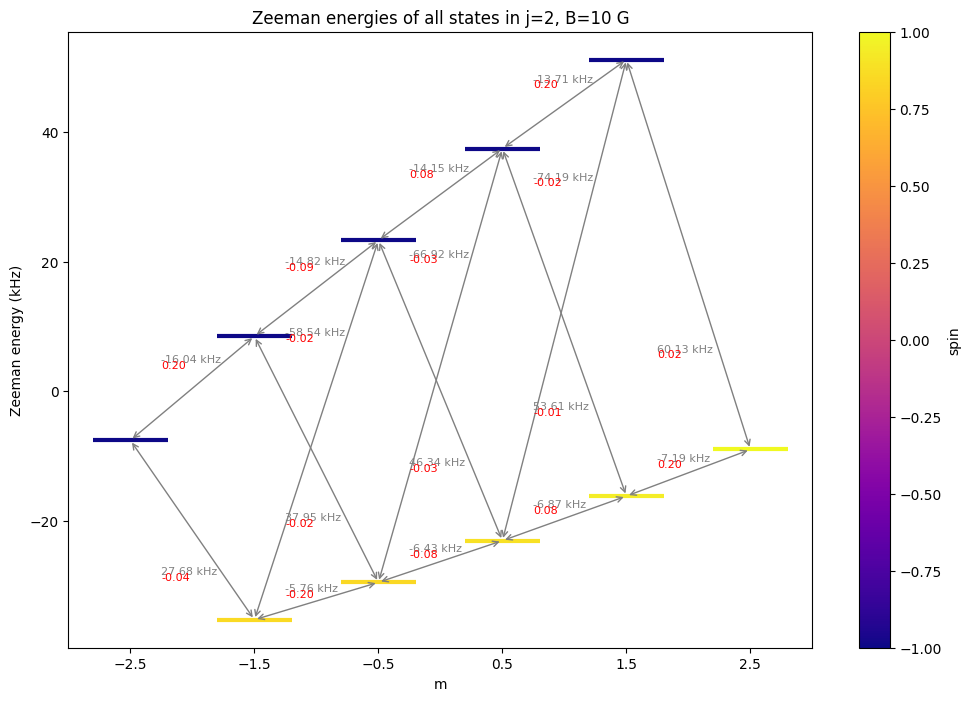

In [ ]:
cah = CaH.create_molecule_data(b_field_gauss=10, j_max=14, gj_list = gj_list, cij_list = cij_list)

# Manifold J=2
cah.plot_zeeman_levels(2)

### State distribution at fixed T=300K

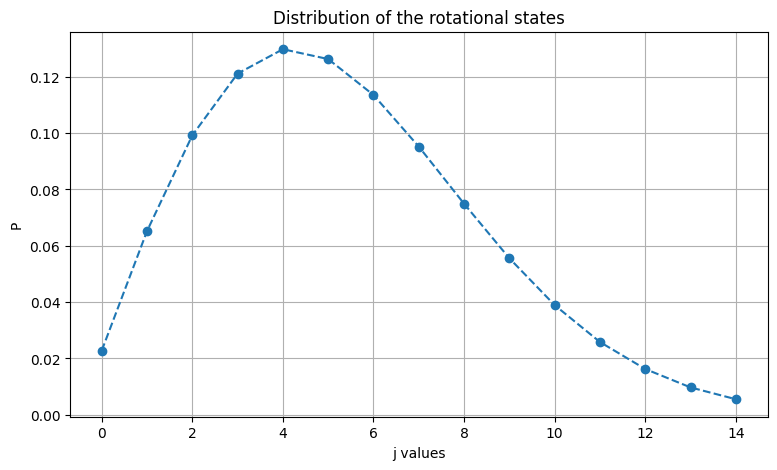

In [ ]:
cah = CaH.create_molecule_data(b_field_gauss=0.3, j_max=14, gj_list = gj_list, cij_list = cij_list)

states = qls.States(cah, 300)
plt.figure(figsize=(9,5))
plt.plot(np.arange(cah.j_max+1), states.j_distribution(), linestyle = "--", marker = "o")
plt.xlabel("j values")
plt.ylabel("P")
plt.title("Distribution of the rotational states")
plt.grid()
plt.show()
plt.close()

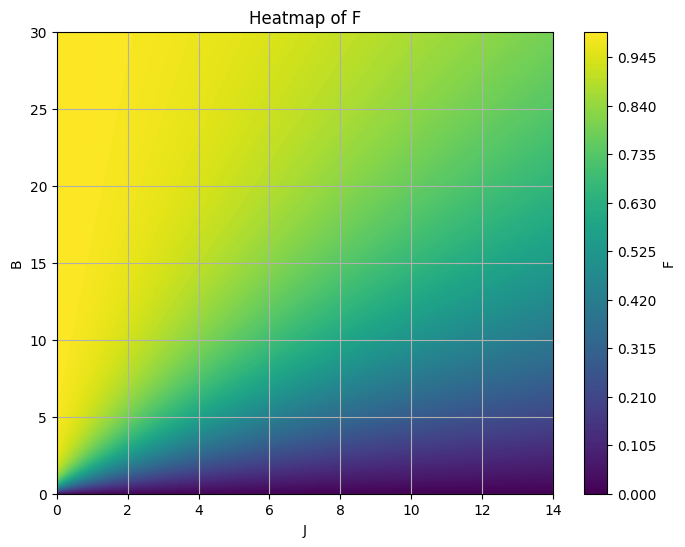

In [9]:
cah = CaH.create_molecule_data(b_field_gauss=10, j_max=14, gj_list = gj_list, cij_list = cij_list)
cah.fom(b_start=0,b_stop=30,j_start=0,j_stop=14)

### Transitions

I analyze the following transitions at different Js, and in different regimes of B:
- Signature transition: it's the target transition in the molecule
- Penultimate transition: it's the transition at m+1 to the right of the signature transition
- Sub-manifold splitting: it's the splitting of the manifold between the states at $\xi = -$ and $\xi = +$ 

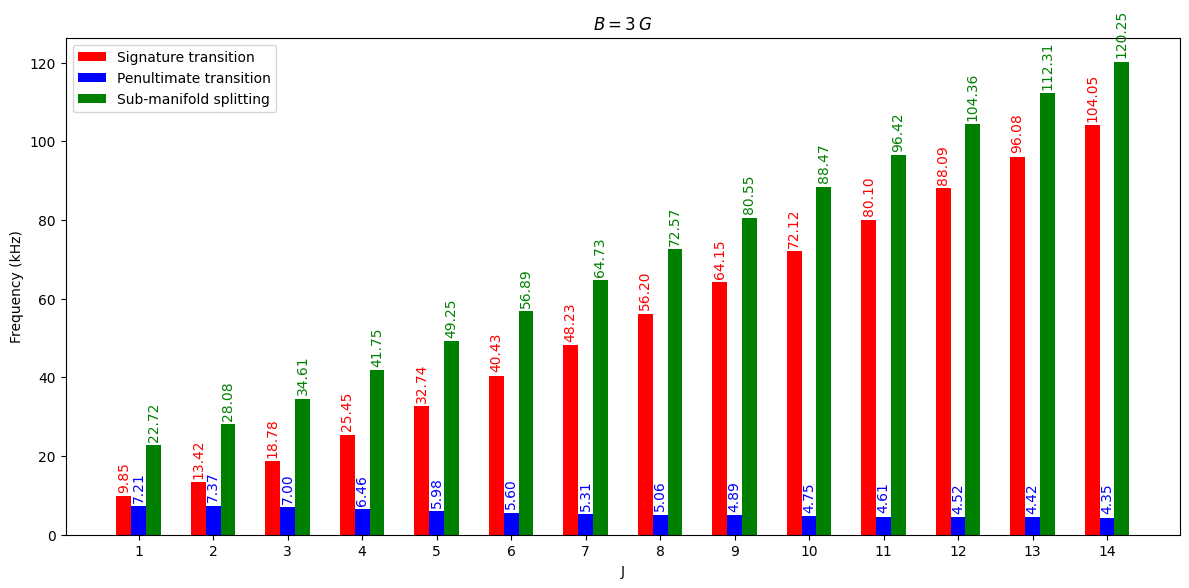

In [ ]:
# Intermediate regime

cah = CaH.create_molecule_data(b_field_gauss=3.6, j_max=14, gj_list = gj_list, cij_list = cij_list)
ut.plot_transitions(cah)

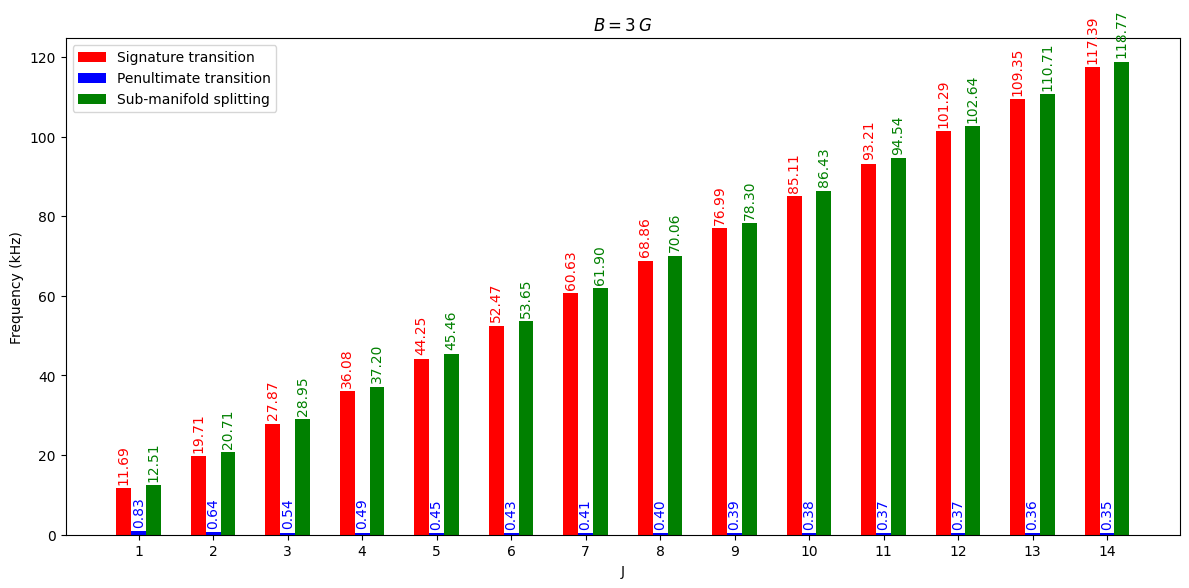

In [ ]:
# Zeeman Regime

cah = CaH.create_molecule_data(b_field_gauss=0.3, j_max=14, gj_list = gj_list, cij_list = cij_list)
ut.plot_transitions(cah)

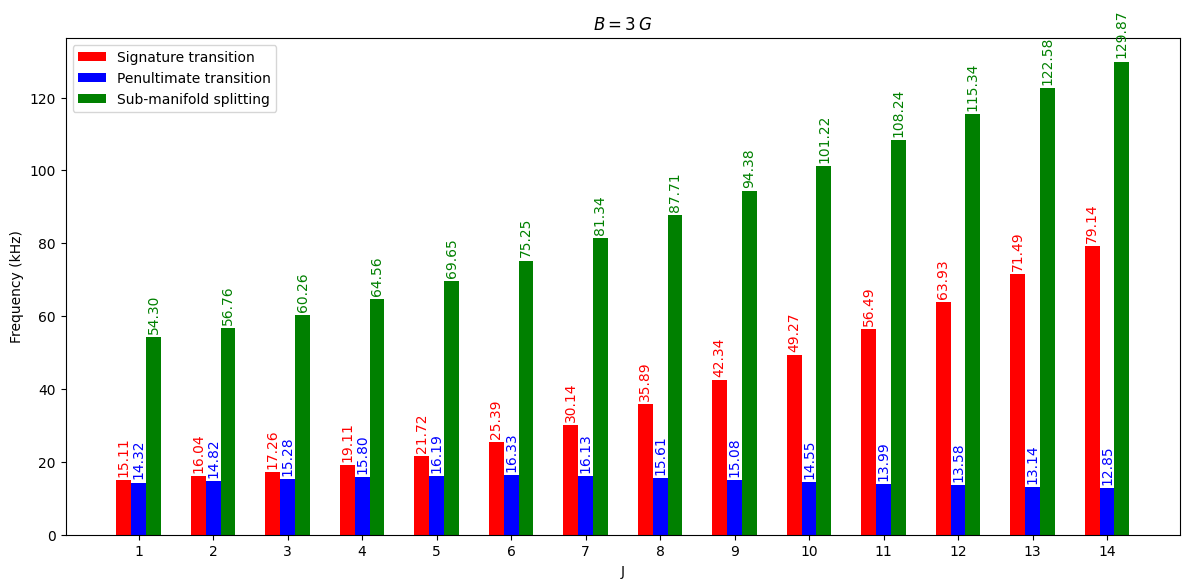

In [ ]:
# Pachen-Back regime

cah = CaH.create_molecule_data(b_field_gauss=10, j_max=14, gj_list = gj_list, cij_list = cij_list)
ut.plot_transitions(cah)

## Quantum Logic Spectroscopy

The data for the simulation are listed in the cell below. <br> 
Here, we perform one pumping procedure at frequency -6 kHz 

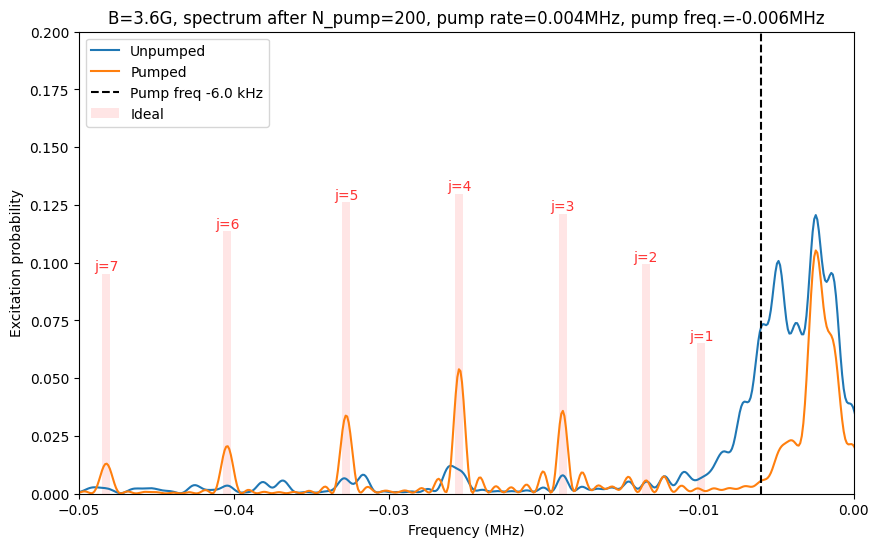

In [ ]:
b_field_gauss = 3.6
j_max = 14

# I compute the molecule 
cah1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max, gj_list = gj_list, cij_list = cij_list)



temperature = 300
# I compute the states1. I do so because i need states1.dist,          J|m|csi|...|states1.dist
                                                                    #  .|.| . |   |     .
                                                                    #  .|.| . |   |     .
                                                                    #  .|.| . |   |     .

states1 = qls.States(cah1, temperature)

# I take the transition_df. For each j (multiplet), i take the energy difference of the target distribution.
signature_transitions = np.array([cah1.transition_df.loc[cah1.transition_df["j"]==j].iloc[0]["energy_diff"] * 1e-3 for j in range(1, cah1.j_max+1)])


# Then I apply the external Raman pulse. 
duration_us = 1000.0
rabi_rate_mhz = 2*np.pi*0.005
max_frequency_mhz = 0.05        # 50 kHz
scan_points = 1000
dephased = False
is_minus = True

# get_spectrum: it takes excitation probability (from get_excitation_probabilities) + states1.dist distribution (from States) and np.dot @ freq.
# Then repeats for the frequencies and returns both the frequencies and the results @ each freq.
# This returns the spectrum before pumping.
frequencies, exc_probs1_before = qls.get_spectrum(cah1, states1.dist, duration_us, rabi_rate_mhz, max_frequency_mhz, scan_points, dephased, is_minus)

# Then I pump the system n times to improve the population
pump_frequency_mhz = -0.006
num_pumps = 200
pump_dephased = True
pump_rabi_rate_mhz = 2*np.pi*0.004
pump_duration_us = 1000.0


# I update the state distribution (@ fixed j) with the exctiation matrix.
# I pump the system multiple times in order to better populate the molecule

for _ in range(num_pumps):
    states1.dist += qls.excitation_matrix(cah1, pump_frequency_mhz, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, is_minus).dot(states1.dist)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(frequencies, exc_probs1_before, label = "Unpumped")     # Plot before pumping

frequencies, exc_probs1_after = qls.get_spectrum(cah1, states1.dist, duration_us, rabi_rate_mhz, max_frequency_mhz, scan_points, dephased, is_minus)

ax.plot(frequencies, exc_probs1_after, label = f"Pumped")      # Plot after pumping



ax.bar(signature_transitions, states1.j_distribution()[1:], color="red", width=0.0005, alpha=0.1, label = "Ideal")
ax.axvline(x=pump_frequency_mhz, color='black', linestyle='--', label=f'Pump freq {pump_frequency_mhz*(1e3)} kHz')
ax.legend()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Excitation probability")
ax.set_title(f"B={b_field_gauss}G, spectrum after N_pump={num_pumps}, pump rate={pump_rabi_rate_mhz/(2*np.pi):.3f}MHz, pump freq.={pump_frequency_mhz}MHz")

a_lim = -max_frequency_mhz
b_lim = 0
ax.set_xlim([a_lim, b_lim])
ax.set_ylim([0, 0.2])

for i in range(j_max):
    if signature_transitions[i] >= a_lim and signature_transitions[i] <= b_lim:
        ax.text(signature_transitions[i], states1.j_distribution()[i+1], f"j={i+1}", ha='center', va='bottom', color='red', alpha=0.8)

plt.show()

The data for the simulation are listed in the cell below. <br> 
Here, we perform twp pumping procedures at frequency -6 kHz and -2 kHz

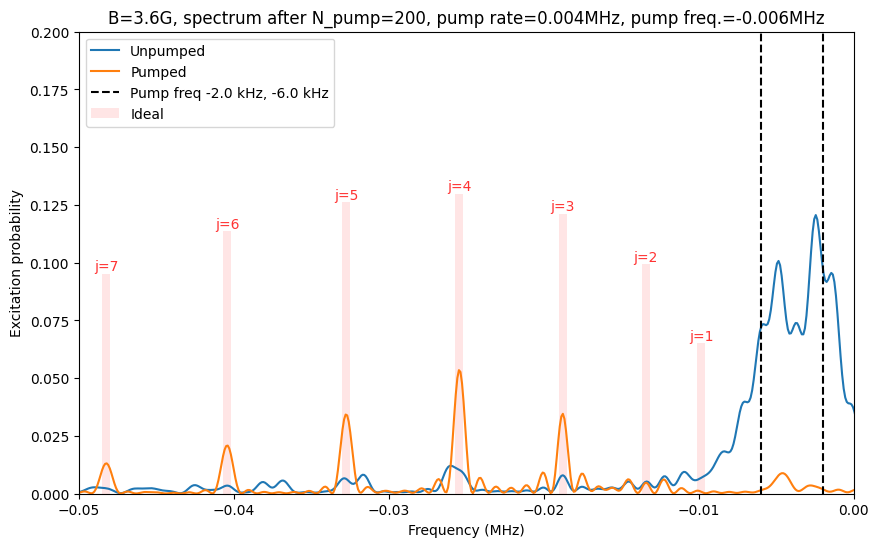

In [ ]:
b_field_gauss = 3.6
j_max = 14

# I compute the molecule 
cah1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max, gj_list = gj_list, cij_list = cij_list)


temperature = 300
# I compute the states1. I do so because i need states1.dist,          J|m|csi|...|states1.dist
                                                                    #  .|.| . |   |     .
                                                                    #  .|.| . |   |     .
                                                                    #  .|.| . |   |     .

states1 = qls.States(cah1, temperature)

# I take the transition_df. For each j (multiplet), i take the energy difference of the target distribution.
signature_transitions = np.array([cah1.transition_df.loc[cah1.transition_df["j"]==j].iloc[0]["energy_diff"] * 1e-3 for j in range(1, cah1.j_max+1)])


# Then I apply the external Raman pulse. 
duration_us = 1000.0
rabi_rate_mhz = 2*np.pi*0.005
max_frequency_mhz = 0.05
scan_points = 1000
dephased = False
is_minus = True

# get_spectrum: it takes excitation probability (from get_excitation_probabilities) + states1.dist distribution (from States) and np.dot @ freq.
# Then repeats for the frequencies and returns both the frequencies and the results @ each freq.
# This returns the spectrum before pumping.
frequencies, exc_probs1_before = qls.get_spectrum(cah1, states1.dist, duration_us, rabi_rate_mhz, max_frequency_mhz, scan_points, dephased, is_minus)

# Then I pump the system n times to improve the population
pump_frequency_mhz_1 = -0.002
num_pumps = 200
pump_dephased = True
pump_rabi_rate_mhz = 2*np.pi*0.004
pump_duration_us = 1000.0


# I update the state distribution (@ fixed j) with the exctiation matrix.
# I pump the system multiple times in order to better populate the molecule

for _ in range(num_pumps):
    states1.dist += qls.excitation_matrix(cah1, pump_frequency_mhz_1, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, is_minus).dot(states1.dist)

# Second pumping procedure at -6 kHz
pump_frequency_mhz_2 = -0.006

for _ in range(num_pumps):
    states1.dist += qls.excitation_matrix(cah1, pump_frequency_mhz_2, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, is_minus).dot(states1.dist)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(frequencies, exc_probs1_before, label = "Unpumped")     # Plot before pumping

frequencies, exc_probs1_after = qls.get_spectrum(cah1, states1.dist, duration_us, rabi_rate_mhz, max_frequency_mhz, scan_points, dephased, is_minus)

ax.plot(frequencies, exc_probs1_after, label = f"Pumped")      # Plot after pumping



ax.bar(signature_transitions, states1.j_distribution()[1:], color="red", width=0.0005, alpha=0.1, label = "Ideal")
ax.axvline(x=pump_frequency_mhz_2, color='black', linestyle='--')
ax.axvline(x=pump_frequency_mhz_1, color='black', linestyle='--', label=f'Pump freq {pump_frequency_mhz_1*(1e3)} kHz, {pump_frequency_mhz_2*(1e3)} kHz')
ax.legend()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Excitation probability")
ax.set_title(f"B={b_field_gauss}G, spectrum after N_pump={num_pumps}, pump rate={pump_rabi_rate_mhz/(2*np.pi):.3f}MHz, pump freq.={pump_frequency_mhz}MHz")

a_lim = -max_frequency_mhz
b_lim = 0
ax.set_xlim([a_lim, b_lim])
ax.set_ylim([0, 0.2])

for i in range(j_max):
    if signature_transitions[i] >= a_lim and signature_transitions[i] <= b_lim:
        ax.text(signature_transitions[i], states1.j_distribution()[i+1], f"j={i+1}", ha='center', va='bottom', color='red', alpha=0.8)

plt.show()